# Basic probabilistic model implimentation



This notebook test on how to use pymc3 to model a basic prbablistic model of the following:

\begin{align}
    \theta &\sim \text{Dir}(\alpha) \in\mathbb{R}^{K} \\
    \phi_{k=1:K} & \sim \text{Dir}(\beta)\\
    z_{j=1:D} & \sim \text{Cat}(\theta)\\
    w_{j=1:D,i=1:N_d} & \sim \text{Cat}(\phi_{z_j})\\
\end{align}

where
- $\theta \in\mathbb{R}^K$ is the paramter of the topic distribution, since it's categorical variable, each $\theta$ will represents the probability of observing a topic. This is global for all documents.
- $\phi_{k=1:K} \in\mathbb{R}^V$ is the parameter for word distirbution (since each topic of the $K$ topic will neecd to generate $V$ words, we have $K$ $V$-dimentional vectors
- $z_{j=1:D} \in\{1,\cdots, K\}$ the topic of each document (in this simple model we assume each document is generated by only one topic.
- $w_{j=1:D,i=1:N_d} \in\{1,\cdots, V\}$ the words in each document



In [26]:
%matplotlib inline
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

env: THEANO_FLAGS=device=cpu,floatX=float64


In [2]:
from sklearn.preprocessing import LabelEncoder

documents = [['Python', 'Scala', 'Python', 'Python', 'Java'],
             ['Scala', 'Python', 'Python', 'Java', 'Scala'],
             ['Python', 'Python', 'Scala', 'Python'],
             ['Java', 'Java', 'Java', 'Scala', 'Scala'],
             ['Scala', 'Scala', 'Scala', 'Python', 'Java', 'Scala', 'deep learning'],
             ['Python', 'Scala', 'Python', 'Python', 'Python', 'machine learning'],
             ['Java', 'Python', 'Python', 'Java', 'Scala'],
             ['deep learning', 'statistics', 'machine learning', 'Python'],
             ['machine learning', 'machine learning', 'deep learning', 'deep learning', 'machine learning'],
             ['statistics', 'Python', 'statistics', 'statistics', 'deep learning', 'Postgres'],
             ['deep learning', 'machine learning', 'machine learning', 'deep learning', 'deep learning', 'Postgres'],
             ['MySQL', 'Cassandra', 'Postgres', 'Postgres', 'Postgres', 'machine learning'],
             ['Cassandra', 'Cassandra', 'Postgres', 'Scala', 'MySQL', 'MySQL']]

# Number of topics
K = 3

# Number of documents 
D = len(documents)

# (Ab)use label encoder for categorical encoding of words
encoder = LabelEncoder()
encoder.fit([word for document in documents for word in document])

# Vocabulary derived from documents
vocabulary = encoder.classes_

# Vocabulary size 
V = len(vocabulary)

# Encoded documents
X = [encoder.transform(d) for d in documents]

In [3]:

import numpy as np
import pymc3 as pm

# Hyper-parameter for uniform Dirichlet prior
alpha = np.ones(K)

# Hyper-parameter for sparse Dirichlet prior
beta = np.ones(V) * 0.3

with pm.Model() as model:
    # Global topic distribution
    theta = pm.Dirichlet('theta', a=alpha)
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(K, V))
    
    # Topic of documents
    z = pm.Categorical('z', p=theta, shape=(D,))
    
    for i in range(D):
        # Words of document
        w = pm.Categorical(f'w_{i}', p=phi[z[i]], observed=X[i])


In [19]:
with model:    
    trace = pm.sample(2000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [phi, theta]
>CategoricalGibbsMetropolis: [z]
100%|██████████| 2500/2500 [00:25<00:00, 97.11it/s] 
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


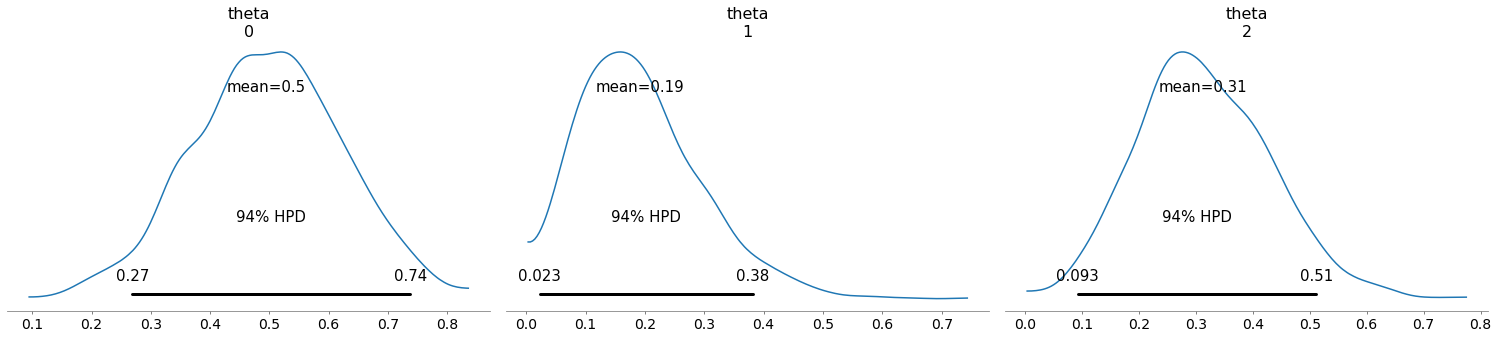

In [20]:
pm.plot_posterior(trace, var_names=['theta']);

## news group data

Loading dataset...
done in 1.152s.
Extracting tf features for LDA...
done in 1.539s.


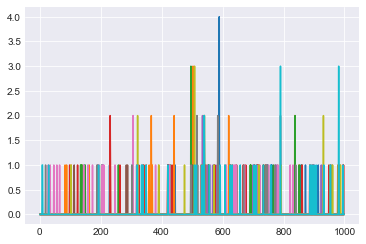

In [28]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))
plt.plot(tf[:10, :].toarray().T);

## Rebuild the model

In [29]:

# Hyper-parameter for uniform Dirichlet prior
alpha = np.ones(K)

# Hyper-parameter for sparse Dirichlet prior
beta = np.ones(V) * 0.3

with pm.Model() as model:
    # Global topic distribution
    theta = pm.Dirichlet('theta', a=alpha)
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(K, V))
    
    # Topic of documents
    z = pm.Categorical('z', p=theta, shape=(D,))
    
    for i in range(D):
        # Words of document
        w = pm.Categorical(f'w_{i}', p=phi[z[i]], observed=tf[i])



AsTensorError: ('Variable type field must be a TensorType.', SparseConstant{csr,int64,shape=(1, 1000),nnz=24}, Sparse[int64, csr])